In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, make_scorer
from math import sqrt
from feature_engine.outliers import Winsorizer

from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [2]:
train = pd.read_csv('../datasets/df_cleaned_v2.csv')

In [3]:
train.head()

,brand,price,Kondisi,TahunKendaraan,Kilometer,Pintu,Dirakit,EngineCC,TenagaPuncak(hp),TenagaPutaranPuncak(Nm),InjeksiLangsung,Aspirasi,Panjang(mm),Lebar(mm),JarakRoda(mm)
0,Toyota,615000000.0,Mobil Bekas,2024.0,5.000,4.0,Complete Built Up (CBU),2752.5,134.0,300.0,Direct Injection,Turbocharged,5341.5,1880.0,3067.5
1,Toyota,175000000.0,Mobil Bekas,2014.0,51.875,5.0,Complete Knock Down (CKD),1998.0,134.0,182.0,Multi-Point Injection,Aspirated,4585.0,1760.0,2750.0
2,Toyota,288000000.0,Mobil Bekas,2012.0,51.875,5.0,Complete Built Up (CBU),2362.0,168.0,220.0,Multi-Point Injection,Aspirated,4885.0,1840.0,2950.0
3,Suzuki,180000000.0,Mobil Bekas,2020.0,45.000,5.0,Complete Knock Down (CKD),1462.0,103.0,138.0,Multi-Point Injection,Aspirated,4450.0,1775.0,2740.0
4,Toyota,199000000.0,Mobil Bekas,2019.0,45.000,5.0,Complete Knock Down (CKD),1496.0,103.0,136.0,Multi-Point Injection,Aspirated,4435.0,1695.0,2685.0


In [4]:
encoders = dict()

def handle_encoding(df, columns):
    for column in columns:
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        df[column] = encoder.transform(df[column])

    return df

In [5]:
categorical_features = ['brand', 'Kondisi', 'Dirakit', 'InjeksiLangsung', 'Aspirasi']

handle_encoding(train, categorical_features)

,brand,price,Kondisi,TahunKendaraan,Kilometer,Pintu,Dirakit,EngineCC,TenagaPuncak(hp),TenagaPutaranPuncak(Nm),InjeksiLangsung,Aspirasi,Panjang(mm),Lebar(mm),JarakRoda(mm)
0,41,615000000.0,1,2024.0,5.000,4.0,1,2752.5,134.0,300.0,0,1,5341.5,1880.0,3067.5
1,41,175000000.0,1,2014.0,51.875,5.0,2,1998.0,134.0,182.0,1,0,4585.0,1760.0,2750.0
2,41,288000000.0,1,2012.0,51.875,5.0,1,2362.0,168.0,220.0,1,0,4885.0,1840.0,2950.0
3,39,180000000.0,1,2020.0,45.000,5.0,2,1462.0,103.0,138.0,1,0,4450.0,1775.0,2740.0
4,41,199000000.0,1,2019.0,45.000,5.0,2,1496.0,103.0,136.0,1,0,4435.0,1695.0,2685.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12713,4,125000000.0,1,2011.0,5.000,5.0,1,1998.0,161.0,360.0,0,1,4673.0,1849.0,2707.0
12714,15,353000000.0,0,2024.0,5.000,5.0,2,1497.0,113.0,144.0,1,0,4315.0,1790.0,2610.0
12715,41,700000000.0,0,2024.0,5.000,5.0,2,2752.5,201.0,415.0,0,1,4795.0,1855.0,2745.0
12716,7,132000000.0,1,2019.0,51.875,5.0,2,1329.0,95.0,121.0,1,0,4190.0,1660.0,2655.0


<Axes: >

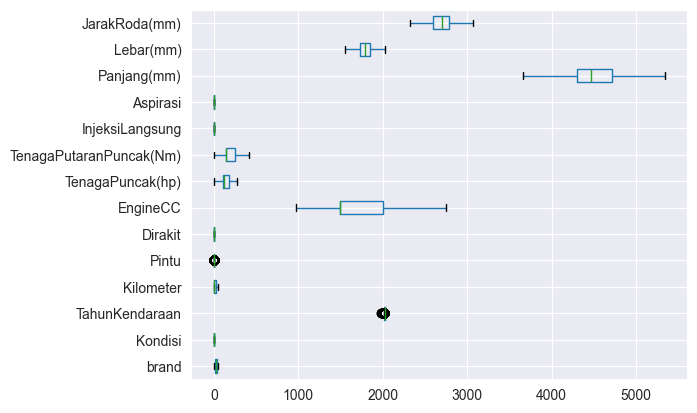

In [6]:
train.drop(columns='price').boxplot(vert=False)

In [7]:
train

,brand,price,Kondisi,TahunKendaraan,Kilometer,Pintu,Dirakit,EngineCC,TenagaPuncak(hp),TenagaPutaranPuncak(Nm),InjeksiLangsung,Aspirasi,Panjang(mm),Lebar(mm),JarakRoda(mm)
0,41,615000000.0,1,2024.0,5.000,4.0,1,2752.5,134.0,300.0,0,1,5341.5,1880.0,3067.5
1,41,175000000.0,1,2014.0,51.875,5.0,2,1998.0,134.0,182.0,1,0,4585.0,1760.0,2750.0
2,41,288000000.0,1,2012.0,51.875,5.0,1,2362.0,168.0,220.0,1,0,4885.0,1840.0,2950.0
3,39,180000000.0,1,2020.0,45.000,5.0,2,1462.0,103.0,138.0,1,0,4450.0,1775.0,2740.0
4,41,199000000.0,1,2019.0,45.000,5.0,2,1496.0,103.0,136.0,1,0,4435.0,1695.0,2685.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12713,4,125000000.0,1,2011.0,5.000,5.0,1,1998.0,161.0,360.0,0,1,4673.0,1849.0,2707.0
12714,15,353000000.0,0,2024.0,5.000,5.0,2,1497.0,113.0,144.0,1,0,4315.0,1790.0,2610.0
12715,41,700000000.0,0,2024.0,5.000,5.0,2,2752.5,201.0,415.0,0,1,4795.0,1855.0,2745.0
12716,7,132000000.0,1,2019.0,51.875,5.0,2,1329.0,95.0,121.0,1,0,4190.0,1660.0,2655.0


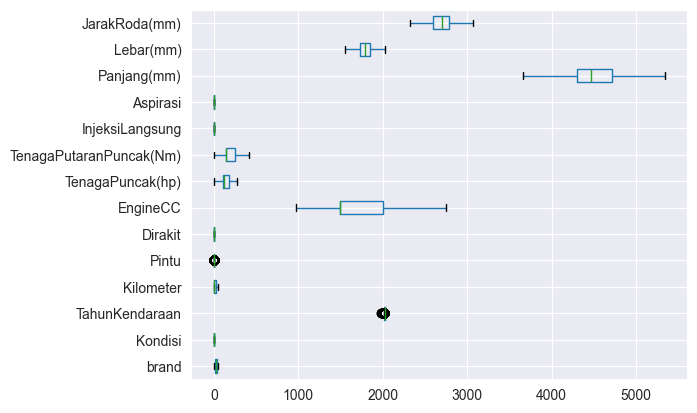

In [8]:
train.drop(columns='price').boxplot(vert=False)

plt.show()

In [9]:
train

,brand,price,Kondisi,TahunKendaraan,Kilometer,Pintu,Dirakit,EngineCC,TenagaPuncak(hp),TenagaPutaranPuncak(Nm),InjeksiLangsung,Aspirasi,Panjang(mm),Lebar(mm),JarakRoda(mm)
0,41,615000000.0,1,2024.0,5.000,4.0,1,2752.5,134.0,300.0,0,1,5341.5,1880.0,3067.5
1,41,175000000.0,1,2014.0,51.875,5.0,2,1998.0,134.0,182.0,1,0,4585.0,1760.0,2750.0
2,41,288000000.0,1,2012.0,51.875,5.0,1,2362.0,168.0,220.0,1,0,4885.0,1840.0,2950.0
3,39,180000000.0,1,2020.0,45.000,5.0,2,1462.0,103.0,138.0,1,0,4450.0,1775.0,2740.0
4,41,199000000.0,1,2019.0,45.000,5.0,2,1496.0,103.0,136.0,1,0,4435.0,1695.0,2685.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12713,4,125000000.0,1,2011.0,5.000,5.0,1,1998.0,161.0,360.0,0,1,4673.0,1849.0,2707.0
12714,15,353000000.0,0,2024.0,5.000,5.0,2,1497.0,113.0,144.0,1,0,4315.0,1790.0,2610.0
12715,41,700000000.0,0,2024.0,5.000,5.0,2,2752.5,201.0,415.0,0,1,4795.0,1855.0,2745.0
12716,7,132000000.0,1,2019.0,51.875,5.0,2,1329.0,95.0,121.0,1,0,4190.0,1660.0,2655.0


In [10]:
X = train.drop(columns='price')
y = train['price']

In [11]:
def split_and_scale(X, y):
    x_scaler = RobustScaler()
    y_scaler = RobustScaler()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

    x_scaler.fit(X_train)
    X_train = pd.DataFrame(x_scaler.transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(x_scaler.transform(X_test), columns=X_test.columns)

    y_train = y_train.values.reshape(-1, 1)
    y_scaler.fit(y_train)
    y_train = pd.DataFrame(y_scaler.transform(y_train), columns=["price"])
    
    y_test = y_test.values.reshape(-1, 1)
    y_test = pd.DataFrame(y_scaler.transform(y_test), columns=["price"])

    return X_train, X_test, y_train, y_test, x_scaler, y_scaler

In [12]:
X_train, X_test, y_train, y_test, _, _ = split_and_scale(X, y)

In [13]:
X_train

,brand,Kondisi,TahunKendaraan,Kilometer,Pintu,Dirakit,EngineCC,TenagaPuncak(hp),TenagaPutaranPuncak(Nm),InjeksiLangsung,Aspirasi,Panjang(mm),Lebar(mm),JarakRoda(mm)
0,-0.500000,0.0,0.2,0.00000,0.0,-1.0,1.393638,1.126761,2.454545,-1.0,1.0,1.276850,1.608696,1.042781
1,0.076923,1.0,-1.0,2.34375,0.0,0.0,0.994036,0.422535,0.472727,0.0,0.0,-0.381862,0.086957,-0.187166
2,-0.500000,0.0,0.2,0.00000,0.0,-1.0,1.298211,1.154930,2.454545,-1.0,1.0,0.775656,0.956522,0.320856
3,-0.115385,1.0,0.0,0.00000,-3.0,-1.0,0.994036,1.000000,1.227273,-1.0,1.0,-1.455847,-0.547826,-1.122995
4,0.423077,0.0,0.0,0.00000,0.0,-1.0,-0.598410,-0.507042,-0.290909,0.0,0.0,-1.813842,-0.869565,-1.443850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10169,0.500000,0.0,0.2,0.00000,-1.0,-1.0,2.494036,0.225352,1.409091,-1.0,1.0,2.103819,0.782609,1.938503
10170,-0.807692,1.0,-0.6,2.34375,0.0,0.0,-0.335984,-0.323944,-0.218182,0.0,0.0,-0.644391,-1.130435,-0.267380
10171,-0.500000,0.0,0.2,0.00000,0.0,0.0,-0.001988,-0.070423,-0.009091,0.0,0.0,-0.346062,0.000000,-0.508021
10172,-0.500000,0.0,0.0,0.00000,-1.0,-1.0,0.000000,0.000000,0.000000,0.0,0.0,0.942721,0.782609,1.310160


In [14]:
y_test

,price
0,1.101036
1,0.046632
2,-0.458549
3,-0.161658
4,-0.166399
...,...
2539,-0.014378
2540,0.046632
2541,-0.168394
2542,0.962435


In [15]:
def make_model(model):
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    result = {
        "r2": r2_score(preds, y_test),
        "mae": mean_absolute_error(preds, y_test),
        "mse": mean_squared_error(preds, y_test ),
        "rmse": sqrt(mean_squared_error(preds, y_test))
    }
    
    result = pd.DataFrame(result, index=[0]) 
    
    return result

In [16]:
models = {
    "Random Forest": RandomForestRegressor(),
    "CatBoost": CatBoostRegressor(),
    "XGBoost": XGBRegressor(),
    "Extra Tree": ExtraTreesRegressor(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "AdaBoost": AdaBoostRegressor(),
    "HGB": HistGradientBoostingRegressor(),
    "GBT": GradientBoostingRegressor(),
    "Gaussian": GaussianProcessRegressor(),
    "Bagging": BaggingRegressor() 
    
}

comparison = pd.DataFrame(columns=["model", "r2", "mae", "mse", "rmse"])

for model_name, model in models.items():
    result = make_model(model)
    result["model"] = model_name
    comparison = pd.concat([comparison, result], ignore_index=True)


Learning rate set to 0.059069
0:	learn: 0.7644552	total: 153ms	remaining: 2m 32s
1:	learn: 0.7304673	total: 155ms	remaining: 1m 17s
2:	learn: 0.6985492	total: 157ms	remaining: 52.3s
3:	learn: 0.6675929	total: 160ms	remaining: 39.8s
4:	learn: 0.6374761	total: 162ms	remaining: 32.3s
5:	learn: 0.6102692	total: 165ms	remaining: 27.4s
6:	learn: 0.5854531	total: 168ms	remaining: 23.8s
7:	learn: 0.5630223	total: 170ms	remaining: 21.1s
8:	learn: 0.5398864	total: 174ms	remaining: 19.1s
9:	learn: 0.5190939	total: 177ms	remaining: 17.5s
10:	learn: 0.4985424	total: 180ms	remaining: 16.2s
11:	learn: 0.4801717	total: 183ms	remaining: 15s
12:	learn: 0.4641100	total: 186ms	remaining: 14.1s
13:	learn: 0.4473940	total: 189ms	remaining: 13.3s
14:	learn: 0.4328340	total: 191ms	remaining: 12.6s
15:	learn: 0.4188694	total: 194ms	remaining: 11.9s
16:	learn: 0.4048777	total: 197ms	remaining: 11.4s
17:	learn: 0.3921422	total: 199ms	remaining: 10.9s
18:	learn: 0.3797420	total: 203ms	remaining: 10.5s
19:	learn: 

In [17]:
comparison

,model,r2,mae,mse,rmse
0,Random Forest,0.983449,0.049843,0.010504,0.102489
1,CatBoost,0.982480,0.058066,0.011095,0.105333
2,XGBoost,0.983534,0.051934,0.010571,0.102816
3,Extra Tree,0.985697,0.043922,0.009168,0.095748
4,Ridge,0.608089,0.307826,0.180835,0.425248
5,Lasso,0.000000,0.653147,0.653273,0.808253
6,AdaBoost,0.679844,0.276671,0.122186,0.349552
7,HGB,0.978289,0.064161,0.013677,0.116950
8,GBT,0.939459,0.113848,0.035237,0.187716
9,Gaussian,0.247466,0.143941,1.919873,1.385595


### Feature Selection for Best Model

In [18]:
def rfe(model):
    min_features_to_select = 1  
    model = model()
    cv = KFold(n_splits=5, shuffle=False)
    scorer = make_scorer(r2_score)

    rfecv = RFECV(
        estimator=model,
        step=1,
        scoring=scorer,
        cv=cv,
        min_features_to_select=min_features_to_select,
        n_jobs=1,
    )

    rfecv.fit(X, y)

    return X.columns[rfecv.support_]

In [19]:
features = rfe(ExtraTreesRegressor)

In [20]:
X = X[features]

X_train, X_test, y_train, y_test, feature_scaler, target_scaler  = split_and_scale(X, y) 

In [21]:
X_train

,brand,Kondisi,TahunKendaraan,EngineCC,TenagaPuncak(hp),TenagaPutaranPuncak(Nm),InjeksiLangsung,Panjang(mm),Lebar(mm),JarakRoda(mm)
0,-0.500000,0.0,0.2,1.393638,1.126761,2.454545,-1.0,1.276850,1.608696,1.042781
1,0.076923,1.0,-1.0,0.994036,0.422535,0.472727,0.0,-0.381862,0.086957,-0.187166
2,-0.500000,0.0,0.2,1.298211,1.154930,2.454545,-1.0,0.775656,0.956522,0.320856
3,-0.115385,1.0,0.0,0.994036,1.000000,1.227273,-1.0,-1.455847,-0.547826,-1.122995
4,0.423077,0.0,0.0,-0.598410,-0.507042,-0.290909,0.0,-1.813842,-0.869565,-1.443850
...,...,...,...,...,...,...,...,...,...,...
10169,0.500000,0.0,0.2,2.494036,0.225352,1.409091,-1.0,2.103819,0.782609,1.938503
10170,-0.807692,1.0,-0.6,-0.335984,-0.323944,-0.218182,0.0,-0.644391,-1.130435,-0.267380
10171,-0.500000,0.0,0.2,-0.001988,-0.070423,-0.009091,0.0,-0.346062,0.000000,-0.508021
10172,-0.500000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.942721,0.782609,1.310160


In [22]:
y_test

,price
0,1.101036
1,0.046632
2,-0.458549
3,-0.161658
4,-0.166399
...,...
2539,-0.014378
2540,0.046632
2541,-0.168394
2542,0.962435


### Hyperparameter tuning

In [23]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 300, step=1),
        'max_depth': trial.suggest_int('max_depth', 2, 20, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20, step=2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20, step=1),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'warm_start': trial.suggest_categorical('warm_start', [True, False]),
        'n_jobs': trial.suggest_int('n_jobs', 10, 500, step=10),
    }

    gbm = ExtraTreesRegressor(**param)

    gbm.fit(X_train, y_train)

    preds = gbm.predict(X_test)
    
    r2 = r2_score(y_test, preds)

    return r2

In [24]:
study = optuna.create_study(direction='maximize')

[I 2024-06-05 05:06:19,969] A new study created in memory with name: no-name-8bece37a-dc66-4f27-bcab-dd762403690d


In [25]:
study.optimize(objective, n_trials=200)

[I 2024-06-05 05:06:20,438] Trial 0 finished with value: 0.6556258555201119 and parameters: {'n_estimators': 276, 'max_depth': 2, 'min_samples_split': 14, 'min_samples_leaf': 15, 'bootstrap': False, 'warm_start': True, 'n_jobs': 350}. Best is trial 0 with value: 0.6556258555201119.
[I 2024-06-05 05:06:20,718] Trial 1 finished with value: 0.8725656666975066 and parameters: {'n_estimators': 112, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': True, 'warm_start': True, 'n_jobs': 150}. Best is trial 1 with value: 0.8725656666975066.
[I 2024-06-05 05:06:20,969] Trial 2 finished with value: 0.9497154738895216 and parameters: {'n_estimators': 152, 'max_depth': 13, 'min_samples_split': 16, 'min_samples_leaf': 20, 'bootstrap': False, 'warm_start': True, 'n_jobs': 90}. Best is trial 2 with value: 0.9497154738895216.
[I 2024-06-05 05:06:21,046] Trial 3 finished with value: 0.8161708835218103 and parameters: {'n_estimators': 15, 'max_depth': 4, 'min_samples_split': 4, '

In [26]:
et = ExtraTreesRegressor(**study.best_params)

make_model(et)

,r2,mae,mse,rmse
0,0.985407,0.049836,0.009312,0.096499


### Save model

In [27]:
import joblib

joblib.dump(et, './out/model.h5')

['./out/model.h5']

In [28]:
for feature in features:
    if feature in categorical_features:
        joblib.dump(encoders[feature], './out/'+ feature.lower() +'-encoders.h5')

In [29]:
joblib.dump(feature_scaler, './out/feature-scaler.h5')
joblib.dump(target_scaler, './out/target-scaler.h5')


['./out/target-scaler.h5']